In [1]:
import synapseclient
from synapseclient import Project, File, Folder
from synapseclient import Schema, Column, Table, Row, RowSet, as_table_columns
import itertools
import pandas as pd
import numpy as np

In [2]:
syn = synapseclient.Synapse()
syn.login()

Welcome, Victor Baham!



In [3]:
divco_bio = pd.read_csv(syn.get('syn51757645').path)
rosmap_bio = pd.read_csv(syn.get('syn21323366').path)
mayo_bio = pd.read_csv(syn.get('syn20827192').path)
msbb_bio = pd.read_csv(syn.get('syn21893059').path)

#### Collapse tissue types into broader categories

In [224]:
tissue_to_category = {'occipital visual cortex': 'brain', 
                     'parahippocampal gyrus': 'brain',
                     'posterior cingulate cortex': 'brain',
                     'serum': 'blood',
                     'Head of caudate nucleus': 'brain',
                     'caudate nucleus': 'brain',
                     'cerebellar cortex': 'brain',
                     'dorsolateral prefrontal cortex': 'brain',
                     'frontal pole': 'brain',
                     'inferior frontal gyrus': 'brain',
                     'superior temporal gyrus': 'brain',
                     'temporal pole': 'brain',
                     'unspecified': 'brain',
                     'cerebellum': 'brain',
                     'temporal cortex': 'brain',
                     'frontal cortex': 'brain'}

In [225]:
rosmap_bio['specimenMetadataSource'] = 'ROSMAP'
mayo_bio['specimenMetadataSource'] = 'MayoRNAseq'
msbb_bio['specimenMetadataSource'] = 'MSBB'

In [226]:
mega_bio = pd.concat([divco_bio, rosmap_bio, mayo_bio, msbb_bio], ignore_index=True)
mega_bio['tissue'] = mega_bio['tissue'].apply(lambda x: tissue_to_category.get(x) if x 
                                              in tissue_to_category.keys() else x)

#### Find number of distinct specimens for each assay type:

#### *Without* grouping by `specimenMetadataSource`:

In [227]:
unique_specs_per_assay = mega_bio.groupby(['assay', 'specimenID'])['specimenID'].nunique()
unique_specs_per_assay_piv_1 = mega_bio.groupby(['assay', 'specimenID'],as_index = False).nunique().pivot('assay'
                    ,'specimenID').fillna(0)
unique_specs_per_assay_piv_2 = mega_bio.groupby(['specimenID', 'assay']).size().unstack('assay', fill_value=0.0)

[WARNING] /var/folders/lg/w3yckgy936lc0r6yw790hjs00000gr/T/ipykernel_9266/2504032784.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  unique_specs_per_assay_piv_1 = mega_bio.groupby(['assay', 'specimenID'],as_index = False).nunique().pivot('assay'



#### *With* grouping by `specimenMetadataSource`:

#### Note: This *barely* reduces the number of rows from the previous iteration, so it may not be worth the effort to group here

In [228]:
unique_specs_per_assay_by_source_piv = mega_bio.groupby(['specimenID', 'assay', 'specimenMetadataSource']).size().unstack('assay', fill_value=0.0)

#### Find number of specimens of each tissue type for each assay type:

#### *Without* grouping by `specimenMetadataSource`:

In [229]:
unique_specs_per_assay_and_tissue = mega_bio.groupby(['assay', 'specimenID', 'tissue'])['specimenID'].count()
unique_specs_per_assay_and_tissue_piv = mega_bio.groupby(['assay', 'tissue'])['specimenID'].count().unstack('tissue', fill_value=0.0)

#### *With* grouping by `specimenMetadataSource`:

In [230]:
unique_specs_per_assay_and_tissue_by_source_piv = mega_bio.groupby(['assay', 'tissue', 'specimenMetadataSource'])['specimenID'].count().unstack('tissue', fill_value=0.0)

In [231]:
#unique_specs_per_assay_and_tissue_by_source_piv.to_csv('AMP-AD_1.0_2.0_data_samples_breakdown.csv')

In [232]:
pd.set_option('display.max_columns', None)

#### ROSMAP stats for Nick Seyfried

In [233]:
rosmap_stats = rosmap_bio.groupby(['individualID', 'assay']).size().unstack('assay', fill_value=0.0)
#rosmap_stats.to_csv('preliminary_rosmap_analytics.csv')
rosmap_stats

assay         Biocrates Bile Acids  Biocrates p180  ChIPSeq  Metabolon  \
individualID                                                             
BC15_Control                   0.0             0.0      0.0        0.0   
GISpool                        0.0             0.0      0.0        0.0   
R1004922                       0.0             0.0      0.0        0.0   
R1012422                       0.0             0.0      1.0        0.0   
R1014260                       0.0             0.0      0.0        0.0   
...                            ...             ...      ...        ...   
R9991313                       0.0             0.0      0.0        1.0   
R9993371                       0.0             0.0      0.0        0.0   
R9993486                       0.0             0.0      0.0        0.0   
R9996478                       0.0             0.0      0.0        1.0   
R9999240                       1.0             2.0      0.0        0.0   

assay         TMT quantitation  label free mass spectrometry  \
individualID                                                   
BC15_Control               0.0                           0.0   
GISpool                  100.0                           0.0   
R1004922                   0.0                           0.0   
R1012422                   0.0                           1.0   
R1014260                   0.0                           0.0   
...                        ...                           ...   
R9991313                   0.0                           1.0   
R9993371                   0.0                           0.0   
R9993486                   0.0                           0.0   
R9996478                   0.0                           1.0   
R9999240                   0.0                           1.0   

assay         methylationArray  mirnaArray  rnaArray  rnaSeq  scrnaSeq  \
individualID                                                             
BC15_Control               0.0         0.0       0.0     1.0       0.0   
GISpool                    0.0         0.0       0.0     0.0       0.0   
R1004922                   0.0         0.0       0.0     0.0       0.0   
R1012422                   1.0         1.0       0.0     0.0       0.0   
R1014260                   0.0         0.0       0.0     1.0       0.0   
...                        ...         ...       ...     ...       ...   
R9991313                   0.0         0.0       0.0     3.0       0.0   
R9993371                   0.0         0.0       0.0     0.0       0.0   
R9993486                   0.0         0.0       0.0     0.0       0.0   
R9996478                   0.0         0.0       0.0     2.0       2.0   
R9999240                   0.0         0.0       0.0     0.0       0.0   

assay         snpArray  wholeGenomeSeq  
individualID                            
BC15_Control       0.0             0.0  
GISpool            0.0             0.0  
R1004922           1.0             0.0  
R1012422           1.0             1.0  
R1014260           0.0             0.0  
...                ...             ...  
R9991313           0.0             1.0  
R9993371           1.0             0.0  
R9993486           1.0             0.0  
R9996478           1.0             1.0  
R9999240           0.0             0.0  

[2560 rows x 13 columns]

Reference: Stefanie Molin, https://opendatascience.com/how-to-pivot-and-plot-data-with-pandas/

In [234]:
from matplotlib import ticker
import distinctipy

# generate a distinct color for each assay
ros_colors = distinctipy.get_colors(len(list(set(rosmap_bio['assay'].astype(str).tolist()))))

ax = rosmap_stats.plot(kind='barh', figsize=(25,500), color=ros_colors,
                       stacked=True, title='ROSMAP assay data per individual')

# formatting
ax.set(xlabel='number of data samples', ylabel='individualID')
ax.legend(title='assay')

# removes the top and right lines from the figure to make it less boxy
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

#### Notes:

* Need to change colors of last three assays in legends so all colors are unique

* Need to lengthen plot

In [235]:
#ax.figure.savefig('preliminary_rosmap_analytics.pdf')

In [236]:
divco_bio

individualID   specimenID dataGenerationSite  organ  \
0         NYBB_17   NYBB_17WGS               NYGC  brain   
1        NYBB_147  NYBB_147WGS               NYGC  brain   
2        NYBB_148  NYBB_148WGS               NYGC  brain   
3        NYBB_153  NYBB_153WGS               NYGC  brain   
4         NYBB_76   NYBB_76WGS               NYGC  brain   
...           ...          ...                ...    ...   
4630     R3682722  sd_b18.127N              Emory  brain   
4631     R7530941  sd_b18.128C              Emory  brain   
4632     R5534945  sd_b18.128N              Emory  brain   
4633     R5756103  sd_b18.129N              Emory  brain   
4634     R7905760  sd_b18.130C              Emory  brain   

                              tissue BrodmannArea  isPostMortem sampleStatus  \
0     dorsolateral prefrontal cortex          BA9          True       frozen   
1     dorsolateral prefrontal cortex          BA9          True       frozen   
2     dorsolateral prefrontal cortex          BA9          True       frozen   
3     dorsolateral prefrontal cortex          BA9          True       frozen   
4     dorsolateral prefrontal cortex          BA9          True       frozen   
...                              ...          ...           ...          ...   
4630  dorsolateral prefrontal cortex          NaN          True       frozen   
4631  dorsolateral prefrontal cortex          NaN          True       frozen   
4632  dorsolateral prefrontal cortex          NaN          True       frozen   
4633  dorsolateral prefrontal cortex          NaN          True       frozen   
4634  dorsolateral prefrontal cortex          NaN          True       frozen   

     nucleicAcidSource             assay specimenMetadataSource  
0            bulk cell    wholeGenomeSeq  AMP-AD_DiverseCohorts  
1            bulk cell    wholeGenomeSeq  AMP-AD_DiverseCohorts  
2            bulk cell    wholeGenomeSeq  AMP-AD_DiverseCohorts  
3            bulk cell    wholeGenomeSeq  AMP-AD_DiverseCohorts  
4            bulk cell    wholeGenomeSeq  AMP-AD_DiverseCohorts  
...                ...               ...                    ...  
4630    not applicable  TMT quantitation  AMP-AD_DiverseCohorts  
4631    not applicable  TMT quantitation  AMP-AD_DiverseCohorts  
4632    not applicable  TMT quantitation  AMP-AD_DiverseCohorts  
4633    not applicable  TMT quantitation  AMP-AD_DiverseCohorts  
4634    not applicable  TMT quantitation  AMP-AD_DiverseCohorts  

[4635 rows x 11 columns]

### Actual ROSMAP stats:

In [237]:
rosmap_lip_bio = pd.read_csv(syn.get('syn26475187').path)
rosmap_cog_bio = pd.read_csv(syn.get('syn24185681').path)
divco_ind = pd.read_csv(syn.get('syn51757646').path)
nps_bio = pd.read_csv(syn.get('syn55251032').path)
nps_ind = pd.read_csv(syn.get('syn55251012').path)

#### Get golden AMP-AD Diverse Cohorts metadata set to get ROS+MAP entries

In [238]:
divco_gold = pd.merge(divco_ind, divco_bio, on='individualID')
divco_ros_bio = divco_gold[(divco_gold['cohort'] == 'ROS') | (divco_gold['cohort'] == 'MAP')]

#### Get golden NPS-AD metadata set to get ROS+MAP entries

In [239]:
nps_gold = pd.merge(nps_ind, nps_bio, on='individualID')
nps_ros_bio = nps_gold[(nps_gold['cohort'] == 'ROS') | (nps_gold['cohort'] == 'MAP')]

#### The below dataframe concatenation *should* represent all ROSMAP biospecimens

In [246]:
rosmap_gold_bio = pd.concat([rosmap_bio, rosmap_cog_bio, divco_gold, nps_gold], ignore_index=True)
rosmap_gold_bio = rosmap_gold_bio[((rosmap_gold_bio['individualID'].str.lower().str.contains('control') == False) & 
                                   (rosmap_gold_bio['individualID'].str.lower().str.contains('gis') == False))]
rosmap_gold_bio['tissue'] = rosmap_gold_bio['tissue'].apply(lambda x: tissue_to_category.get(x) if x 
                                              in tissue_to_category.keys() else x)

In [402]:
rosmap_gold_stats = rosmap_gold_bio.groupby(['individualID', 'assay']).size().unstack('assay', fill_value=0.0)

memberships = rosmap_gold_bio.groupby('individualID')['assay'].apply(list).tolist()

rosmap_gold_stats_ups = from_memberships(memberships, data=rosmap_gold_stats)
UpSet(rosmap_gold_stats_ups)

df = pd.read_csv('demo_2.csv')
df = df.set_index(df['wholeGenomeSeq'] == 1).set_index(df['scrnaSeq'] == 1, append=True).set_index(df['snrnaSeq'] == 1, append=True).set_index(df['TMT quantitation'] == 1, append=True).set_index(df['label free mass spectrometry'] == 1, append=True).set_index(df['Biocrates Bile Acids'] == 1, append=True).set_index(df['Biocrates p180'] == 1, append=True).set_index(df['Metabolon'] == 1, append=True).set_index(df['10x multiome'] == 1, append=True)
df

individualID  \
wholeGenomeSeq scrnaSeq snrnaSeq TMT quantitation label free mass spectrometry Biocrates Bile Acids Biocrates p180 Metabolon 10x multiome                
False          False    False    False            False                        False                False          False     False                1005   
                                 True             False                        False                False          False     False              100786   
                                 False            False                        False                False          False     False                1010   
                                                                                                                             False                1015   
                                 True             False                        False                False          False     False              101584   
...                                                                                                                                                ...   
True           False    False    False            True                         False                False          True      False            R9991313   
                        True     True             False                        False                False          False     False            R9991868   
                        False    False            True                         False                False          True      False            R9996478   
False          False    False    False            False                        False                True           False     False            R9999240   
True           False    True     False            True                         True                 True           False     False            R9999240   

                                                                                                                                          tissue  \
wholeGenomeSeq scrnaSeq snrnaSeq TMT quantitation label free mass spectrometry Biocrates Bile Acids Biocrates p180 Metabolon 10x multiome          
False          False    False    False            False                        False                False          False     False         brain   
                                 True             False                        False                False          False     False         brain   
                                 False            False                        False                False          False     False         brain   
                                                                                                                             False         brain   
                                 True             False                        False                False          False     False         brain   
...                                                                                                                                          ...   
True           False    False    False            True                         False                False          True      False         brain   
                        True     True             False                        False                False          False     False         brain   
                        False    False            True                         False                False          True      False         brain   
False          False    False    False            False                        False                True           False     False         blood   
True           False    True     False            True                         True                 True           False     False         brain   

                                                                                                                                           TMT quantitation  \
wholeGenomeSeq scrnaSeq snrnaSeq TMT quantitation l

#### Upset plot

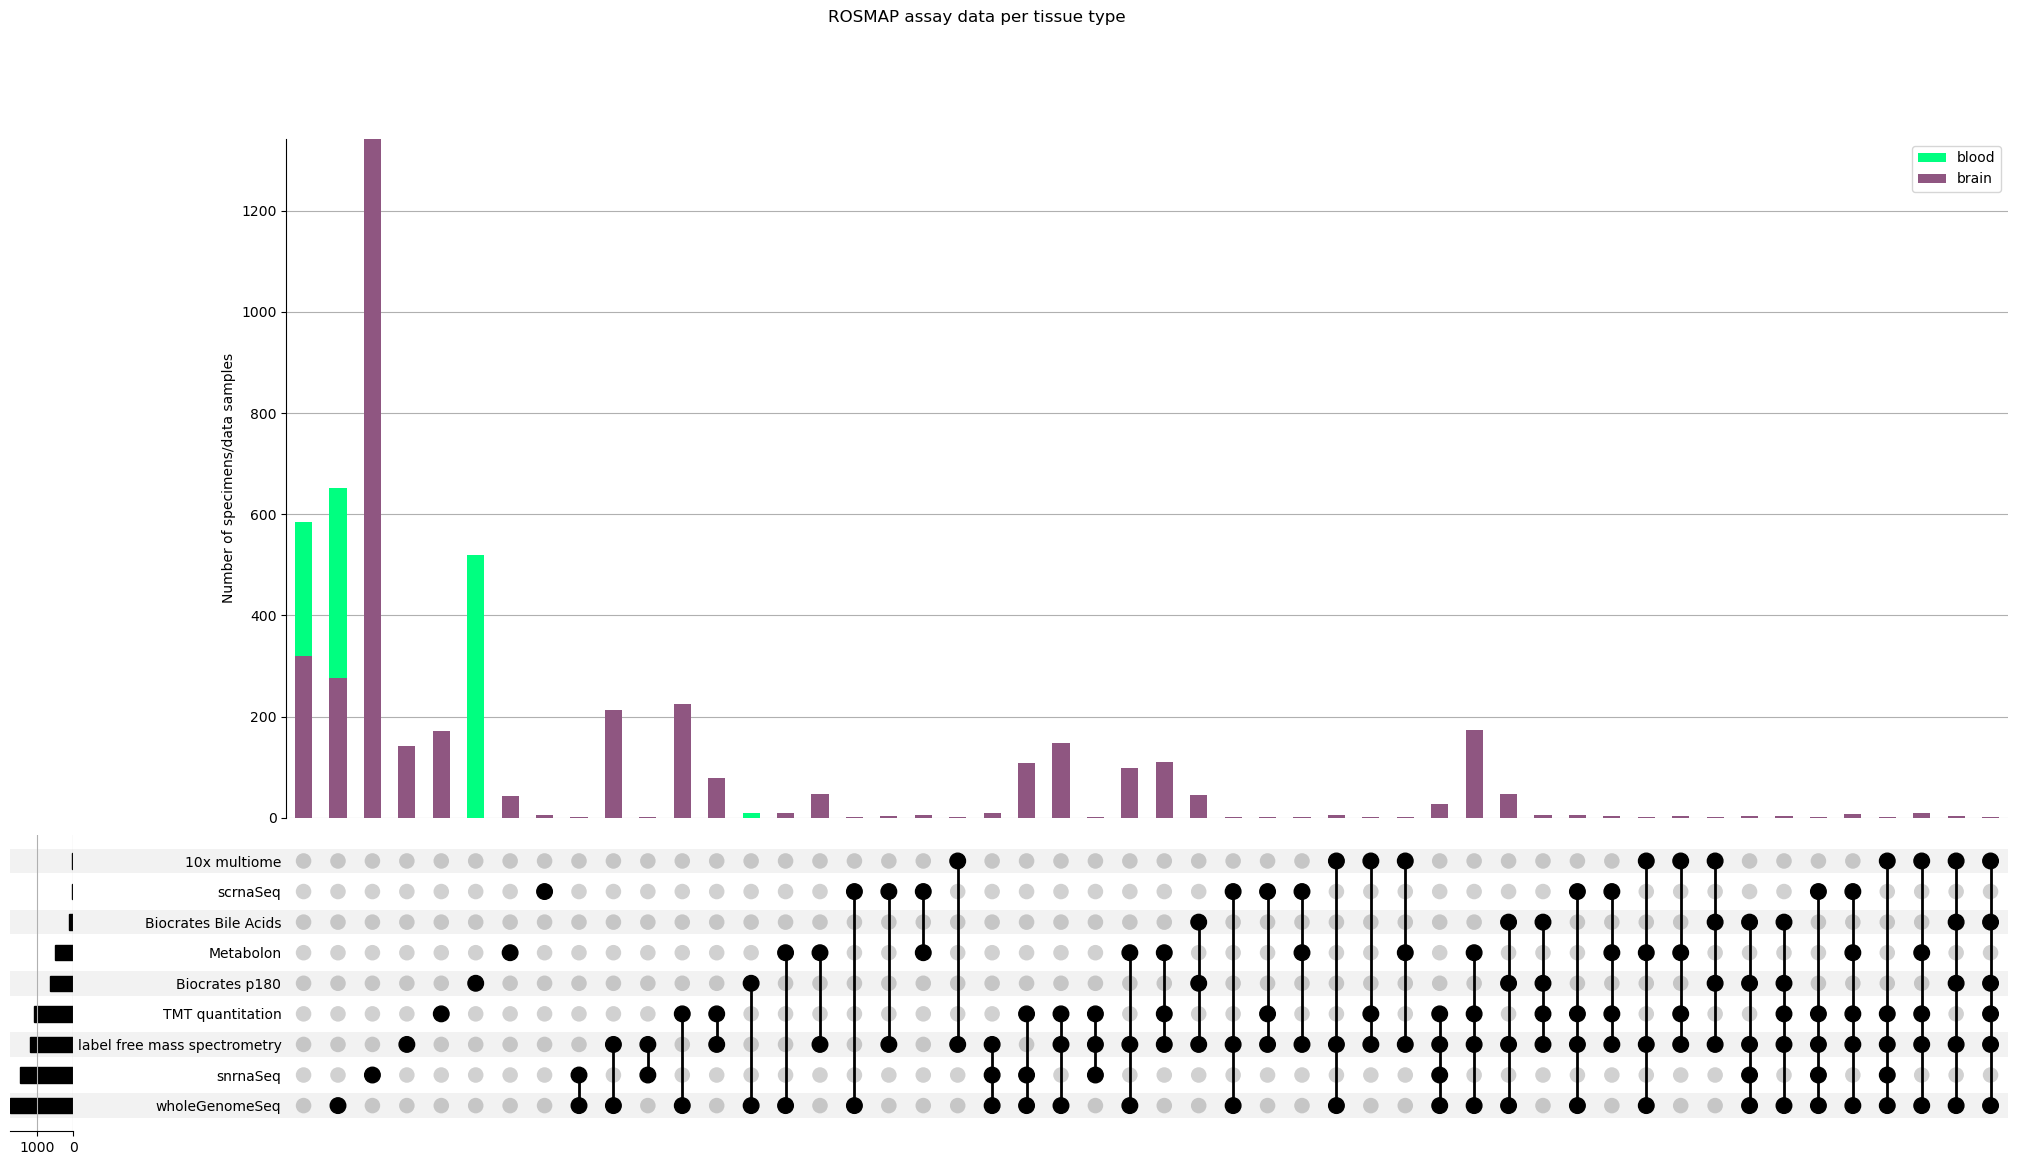

In [404]:
from matplotlib import cm
from matplotlib import pyplot as plt

from upsetplot import UpSet
from upsetplot import from_memberships
from upsetplot import plot

rosmap_ups = from_memberships(rosmap_gold_bio.assay.str.split(","), data=rosmap_gold_bio)

upset = UpSet(df, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="tissue", colors=ros_colors, title="Number of specimens/data samples", elements=20
)
upset.plot()


plt.suptitle("ROSMAP assay data per tissue type")
plt.savefig('ROSMAP_upset_plot.png')
plt.show()

In [200]:
rosmap_metabo_bio = rosmap_gold_bio[rosmap_gold_bio['assay'].isin( 
                                    ['Brain Biocrates bile acids', 'Brain Metabolon' , 
                                     'Brain Biocrates p180', 'Serum Biocrates p180', 
                                     'Plasma lipidomics (LC/MSMS)', 'Brain lipidomics (LC/MSMS)'])]
#rosmap_metabo_bio

#### Venn diagram with just the metabolomics categories

## End of ROSMAP-specific section

#### Recreate gold standard AMP-AD 1.0/2.0 biospecimen metadata

In [48]:
mega_bio = mega_bio[((mega_bio['individualID'].str.lower().str.contains('control') == False) & 
                                   (mega_bio['individualID'].str.lower().str.contains('gis') == False))]

In [49]:
mega_bio

individualID          specimenID dataGenerationSite  organ  \
0                    NYBB_17          NYBB_17WGS               NYGC  brain   
1                   NYBB_147         NYBB_147WGS               NYGC  brain   
2                   NYBB_148         NYBB_148WGS               NYGC  brain   
3                   NYBB_153         NYBB_153WGS               NYGC  brain   
4                    NYBB_76          NYBB_76WGS               NYGC  brain   
...                      ...                 ...                ...    ...   
23266  AMPAD_MSSM_0000009439   179091_NEU_rnaseq                NaN  brain   
23267  AMPAD_MSSM_0000009439  179091_OLIG_rnaseq                NaN  brain   
23268  AMPAD_MSSM_0000068806  179321_MGAS_rnaseq                NaN  brain   
23269  AMPAD_MSSM_0000068806   179321_NEU_rnaseq                NaN  brain   
23270  AMPAD_MSSM_0000068806  179321_OLIG_rnaseq                NaN  brain   

                  tissue BrodmannArea isPostMortem sampleStatus  \
0      prefrontal cortex          BA9         True       frozen   
1      prefrontal cortex          BA9         True       frozen   
2      prefrontal cortex          BA9         True       frozen   
3      prefrontal cortex          BA9         True       frozen   
4      prefrontal cortex          BA9         True       frozen   
...                  ...          ...          ...          ...   
23266    temporal cortex         36.0         True       frozen   
23267    temporal cortex         36.0         True       frozen   
23268    temporal cortex         36.0         True       frozen   
23269    temporal cortex         36.0         True       frozen   
23270    temporal cortex         36.0         True       frozen   

      nucleicAcidSource           assay specimenMetadataSource  \
0             bulk cell  wholeGenomeSeq  AMP-AD_DiverseCohorts   
1             bulk cell  wholeGenomeSeq  AMP-AD_DiverseCohorts   
2             bulk cell  wholeGenomeSeq  AMP-AD_DiverseCohorts   
3             bulk cell  wholeGenomeSeq  AMP-AD_DiverseCohorts   
4             bulk cell  wholeGenomeSeq  AMP-AD_DiverseCohorts   
...                 ...             ...                    ...   
23266     sorted nuclei          rnaSeq                   MSBB   
23267     sorted nuclei          rnaSeq                   MSBB   
23268     sorted nuclei          rnaSeq                   MSBB   
23269     sorted nuclei          rnaSeq                   MSBB   
23270     sorted nuclei          rnaSeq                   MSBB   

      specimenIdSource  tissueWeight  tissueVolume      cellType fastingState  \
0                  NaN           NaN           NaN           NaN          NaN   
1                  NaN           NaN           NaN           NaN          NaN   
2                  NaN           NaN           NaN           NaN          NaN   
3                  NaN           NaN           NaN           NaN          NaN   
4                  NaN           NaN           NaN           NaN          NaN   
...                ...           ...           ...           ...          ...   
23266              NaN           NaN           NaN         NeuN+          NaN   
23267              NaN           NaN           NaN  NeuN-_sox10+          NaN   
23268              NaN           NaN           NaN  NeuN-_sox10-          NaN   
23269              NaN           NaN           NaN         NeuN+          NaN   
23270              NaN           NaN           NaN  NeuN-_sox10+          NaN   

      samplingAge samplingAgeUnits  visitNumber exclude excludeReason  \
0             NaN              NaN          NaN     NaN           NaN   
1             NaN              NaN          NaN     NaN           NaN   
2             NaN              NaN          NaN     NaN           NaN   
3             NaN              NaN          NaN     NaN           NaN   
4             NaN              NaN          NaN     NaN           NaN   
...           ...              ...          ...     ...           ... 

#### 5/2 AMP-AD 1.0/2.0 summary by individualID

In [104]:
mega_bio = pd.concat([divco_bio, rosmap_gold_bio, mayo_bio, msbb_bio], ignore_index=True)
mega_bio['tissue'] = mega_bio['tissue'].apply(lambda x: tissue_to_category.get(x) if x 
                                              in tissue_to_category.keys() else x)

mega_bio = mega_bio[((mega_bio['individualID'].str.lower().str.contains('control') == False) & 
                                   (mega_bio['individualID'].str.lower().str.contains('gis') == False))]

# drop rows where there exists no individualID or specimenID
mega_bio

individualID          specimenID dataGenerationSite  organ  \
0                    NYBB_17          NYBB_17WGS               NYGC  brain   
1                   NYBB_147         NYBB_147WGS               NYGC  brain   
2                   NYBB_148         NYBB_148WGS               NYGC  brain   
3                   NYBB_153         NYBB_153WGS               NYGC  brain   
4                    NYBB_76          NYBB_76WGS               NYGC  brain   
...                      ...                 ...                ...    ...   
29769  AMPAD_MSSM_0000009439   179091_NEU_rnaseq                NaN  brain   
29770  AMPAD_MSSM_0000009439  179091_OLIG_rnaseq                NaN  brain   
29771  AMPAD_MSSM_0000068806  179321_MGAS_rnaseq                NaN  brain   
29772  AMPAD_MSSM_0000068806   179321_NEU_rnaseq                NaN  brain   
29773  AMPAD_MSSM_0000068806  179321_OLIG_rnaseq                NaN  brain   

                  tissue BrodmannArea isPostMortem sampleStatus  \
0      prefrontal cortex          BA9         True       frozen   
1      prefrontal cortex          BA9         True       frozen   
2      prefrontal cortex          BA9         True       frozen   
3      prefrontal cortex          BA9         True       frozen   
4      prefrontal cortex          BA9         True       frozen   
...                  ...          ...          ...          ...   
29769    temporal cortex         36.0         True       frozen   
29770    temporal cortex         36.0         True       frozen   
29771    temporal cortex         36.0         True       frozen   
29772    temporal cortex         36.0         True       frozen   
29773    temporal cortex         36.0         True       frozen   

      nucleicAcidSource           assay specimenMetadataSource  \
0             bulk cell  wholeGenomeSeq  AMP-AD_DiverseCohorts   
1             bulk cell  wholeGenomeSeq  AMP-AD_DiverseCohorts   
2             bulk cell  wholeGenomeSeq  AMP-AD_DiverseCohorts   
3             bulk cell  wholeGenomeSeq  AMP-AD_DiverseCohorts   
4             bulk cell  wholeGenomeSeq  AMP-AD_DiverseCohorts   
...                 ...             ...                    ...   
29769     sorted nuclei          rnaSeq                   MSBB   
29770     sorted nuclei          rnaSeq                   MSBB   
29771     sorted nuclei          rnaSeq                   MSBB   
29772     sorted nuclei          rnaSeq                   MSBB   
29773     sorted nuclei          rnaSeq                   MSBB   

      specimenIdSource  tissueWeight  tissueVolume      cellType fastingState  \
0                  NaN           NaN           NaN           NaN          NaN   
1                  NaN           NaN           NaN           NaN          NaN   
2                  NaN           NaN           NaN           NaN          NaN   
3                  NaN           NaN           NaN           NaN          NaN   
4                  NaN           NaN           NaN           NaN          NaN   
...                ...           ...           ...           ...          ...   
29769              NaN           NaN           NaN         NeuN+          NaN   
29770              NaN           NaN           NaN  NeuN-_sox10+          NaN   
29771              NaN           NaN           NaN  NeuN-_sox10-          NaN   
29772              NaN           NaN           NaN         NeuN+          NaN   
29773              NaN           NaN           NaN  NeuN-_sox10+          NaN   

      samplingAge samplingAgeUnits  visitNumber exclude excludeReason  \
0             NaN              NaN          NaN     NaN           NaN   
1             NaN              NaN          NaN     NaN           NaN   
2             NaN              NaN          NaN     NaN           NaN   
3             NaN              NaN          NaN     NaN           NaN   
4             NaN              NaN          NaN     NaN           NaN   
...           ...              ...          ...     ...           ... 